In [125]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [126]:
def symbolmapping(file_number):        
    symbol_file_path = r"D:\3 - Data\symbolmapping.csv"
    symbols = pd.read_csv(symbol_file_path , sep="|")
  
    # Get the symbol for the extracted file number
    symbol_row = symbols[symbols["FILE_NAME"] == int(file_number)]

    if not symbol_row.empty:
        # If a matching symbol is found, print it
        symbol = symbol_row["SYMBOL"].values[0]
        print(f"Symbol for the file number {file_number}: {symbol}")
    else:
        # If no matching symbol is found, print a message
        print(f"No symbol found for file number {file_number}")
        symbol = 00000
    return symbol

In [127]:
def Create_csv(target_csv_file):
    # Create an output CSV file
    output_file = r"D:\2 - Price Prediction\LSTM\\" + str(target_csv_file)

    # Write the header to the CSV file
    pd.DataFrame(columns=['DATE', 'LTP']).to_csv(output_file, index=False)
    # Specify the root folder
    root_folder = r"D:\3 - Data\Annual Data"
    # Start the recursive iteration
    process_folder(root_folder , target_csv_file , output_file)

def process_folder(folder_path , target_csv_file , output_file):
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        if os.path.isdir(subfolder_path):
            process_folder(subfolder_path , target_csv_file , output_file)
            process_specific_csv(subfolder_path , target_csv_file , output_file)

def process_specific_csv(subfolder_path , target_csv_file , output_file):
    # Specify the name of the specific CSV file you are looking for

    # Check if the specific CSV file exists in the current subfolder
    if target_csv_file in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, target_csv_file)

        # Print file with specific CSV
        #print("\n\nFound specific CSV file:", target_csv_file)
        #print("File path is", file_path, end="\n\n")

        # Read the specific CSV file line by line to handle errors
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter='|')
                
            # Get header and find index of DATE and LTP
            header = next(csv_reader)
            date_index = header.index('DATE')
            ltp_index = header.index('LTP')

            # Iterate over lines in the CSV file
            for line in csv_reader:
                date_value = pd.to_datetime(line[date_index], format='%Y%m%d').strftime('%Y-%m-%d')
                try:
                    # Extract DATE and LTP values based on the indices
                    
                    ltp_value = float(line[ltp_index])

                    # Print or process the extracted values as needed
                    #print("DATE:", date_value, "LTP:", ltp_value)

                    # You can append the values to your output file here

                except ValueError:
                    # If a ValueError occurs, try extracting from the next column
                    try:
                        ltp_value = float(line[ltp_index + 1])
                        #print("DATE:", date_value, "LTP:", ltp_value)
                        # You can append the values to your output file here

                    except (ValueError, IndexError):
                        print(f"Error extracting values from line: {line}")
                        continue  # Continue to the next line in case of an error
                
                # Append the values to the output CSV file
                with open(output_file, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([date_value, ltp_value])

In [128]:
def split_sequence(window_size, scaled_data):
    x_train = []
    y_train = []

    for x in range(window_size, len(scaled_data)):
        x_train.append(scaled_data[x - window_size:x, 0])
        y_train.append(scaled_data[x, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

    return x_train, y_train, x_val, y_val

In [129]:
def predict_price(scaled_data, model, data , scaler):
    global target_csv_file , window_size
    x_test = []

    for x in range(len(scaled_data) - window_size, len(scaled_data)):
        x_test.append(scaled_data[x - window_size:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    #print("Test data set \n")
    test_df = pd.DataFrame(data.iloc[len(scaled_data) - window_size : len(scaled_data)])
    real_data = test_df.copy()
    test_df["predictions"] = predicted_prices
    #print(test_df)
    all_Predictions = pd.DataFrame(test_df['predictions'])
    #display(all_Predictions)
    #actual_prices = data["LTP"].tail(len(predicted_prices)) 
    #plt.plot(predicted_prices, label="Predicted Price", color='red')
    #plt.plot(actual_prices, label="Actual Price", color='blue')


    plt.plot(test_df["predictions"], label="Predicted Price", color='red')
    plt.plot(test_df["LTP"], label="Actual Price", color='blue')
    plt.title("Price Prediction (Test Data) for " + target_csv_file[:-4])
    plt.xlabel('Time')
    plt.xticks(rotation='vertical')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
    mse = mean_squared_error(test_df["predictions"], test_df["LTP"])
    print("Mean Squared Error:", mse)
    #print(real_data)
    real_data = scaler.fit_transform(real_data['LTP'].values.reshape(-1,1))
    #print(real_data)

    return real_data , test_df

In [130]:
def futurePrediction (model , real_data , scaler , num_days_to_predict , data , test_df):
    import pandas as pd
    global target_csv_file

    real_data_for_a_day = np.array([real_data])
    real_data_for_a_day = np.reshape(real_data_for_a_day, (real_data_for_a_day.shape[0],real_data_for_a_day.shape[1],1))
    prediction = model.predict(real_data_for_a_day)
    prediction = scaler.inverse_transform(prediction)
    print(f"Next day Prediction: {prediction}")



    # Reshape the data for the model
    real_data_for_next_days = np.array([real_data])
    real_data_for_next_days = np.reshape(real_data_for_next_days, (real_data_for_next_days.shape[0], real_data_for_next_days.shape[1], 1))

    # Make predictions for the next days
    predicted_values = []
    for _ in range(num_days_to_predict):
        prediction = model.predict(real_data_for_next_days)
        #prediction = scaler.inverse_transform(prediction)
        predicted_values.append(prediction[0, 0])

        # Update real_data for the next iteration
        real_data_for_next_days = np.roll(real_data_for_next_days, -1) 
        real_data_for_next_days[0, -1, 0] = prediction[0, 0]

    # Create a new DataFrame with the predicted values and corresponding index
    index_dates = pd.date_range(data.index[-1], periods=num_days_to_predict + 1, freq='D')[1:]
    predicted_df = pd.DataFrame(predicted_values, index=index_dates, columns=['predictions'])

    # Inverse transform the specific column
    predicted_df["predictions"] = scaler.inverse_transform(predicted_df[["predictions"]])

    # Print the predicted DataFrame
    #print(predicted_df)
    

    plt.plot(predicted_df, label="Predicted Price", color='blue')
    plt.title("Price Future Prediction for " + target_csv_file[:-4])
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


    # Assuming test_df["predictions"] and predicted_df['predictions'] are two Series
    # Convert the index to datetime if it's not already in datetime format
    test_df["predictions"].index = pd.to_datetime(test_df["predictions"].index)
    predicted_df['predictions'].index = pd.to_datetime(predicted_df['predictions'].index)

    # Create DataFrames with the predictions
    df1 = pd.DataFrame({'predictions': test_df["predictions"]})
    df2 = pd.DataFrame({'predictions': predicted_df['predictions']})

    # Concatenate them along the rows (axis=0)
    all_predictions = pd.concat([df1, df2], axis=0)

    # Display the result
    #print(all_predictions)


    #import matplotlib.pyplot as plt
    #
    ## Assuming 'test_df' is your DataFrame with "predictions" and "LTP" columns
    ## Assuming 'predicted_df' is the DataFrame with "Predicted" column
    #
    ## Plotting both sets of data in the same plot
    #plt.plot(test_df.index.astype(str), test_df["predictions"], label="Predicted Price", color='red')
    ##plt.plot(all_predictions.index.astype(str), all_predictions["predictions"], label="Predicted Price", color='red')
    #plt.plot(test_df.index.astype(str), test_df["LTP"], label="Actual Price", color='blue')
    #plt.plot(predicted_df.index.astype(str), predicted_df['predictions'], label="Predicted Price (Future)", color='black')
    #
    ## Adding titles and labels
    #plt.title("Price Prediction for " + target_csv_file[:-4])
    #plt.xticks(rotation='vertical')
    #plt.xlabel('Time')
    #plt.ylabel('Price')
    #
    ## Adding a legend
    #plt.legend()
    #
    ## Display the plot
    #plt.show()


    #import matplotlib.pyplot as plt
    #
    ## Assuming 'test_df' is your DataFrame with "predictions" and "LTP" columns
    ## Assuming 'predicted_df' is the DataFrame with "Predicted" column
    #
    ## Plotting both sets of data in the same plot
    ##plt.plot(test_df.index.astype(str), test_df["predictions"], label="Predicted Price", color='red')
    #plt.plot(all_predictions.index.astype(str), all_predictions["predictions"], label="Predicted Price", color='red')
    #plt.plot(test_df.index.astype(str), test_df["LTP"], label="Actual Price", color='blue')
    ##plt.plot(predicted_df.index.astype(str), predicted_df['predictions'], label="Predicted Price (Future)", color='green')
    #
    ## Adding titles and labels
    #plt.title("Price Prediction for " + target_csv_file[:-4])
    #plt.xticks(rotation='vertical')
    #plt.xlabel('Time')
    #plt.ylabel('Price')
    #
    ## Adding a legend
    #plt.legend()
    #
    ## Display the plot
    #plt.show()
    return all_predictions


In [131]:
    
def latestData(all_predictions , test_df):
    global target_csv_file
    file_path = r"D:\3 - Data\2024"
    file_name = target_csv_file
    file = os.path.join(file_path, file_name)

    # Read the specific CSV file into a dataframe
    df_new = pd.read_csv(file, sep='|')

    # Convert the "DATE" column to datetime
    df_new['DATE'] = pd.to_datetime(df_new['DATE'], format='%Y%m%d')

    # Select only the "DATE" and "VOL" columns
    data_updated = df_new[["DATE", "LTP"]]
    #display(data_updated.head())
    #data_updated.info()
    #data_updated.describe()

    data_updated = data_updated.set_index("DATE")

    symbol = symbolmapping(file_name[:-4])

    plt.figure(figsize=(12,6))
    plt.plot(all_predictions.index.astype(str), all_predictions["predictions"], label="Predicted Price", color='red')
    plt.plot(test_df.index.astype(str), test_df["LTP"], label="Actual Price", color='blue')
    plt.plot(data_updated.index.astype(str), data_updated["LTP"], label="Actual updated Price", color='green')

    plt.title("Price Prediction for file " + target_csv_file[:-4] + " symbol: " + str(symbol))
    plt.xticks(rotation='vertical')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    plt.tight_layout()
    output_file_path = r"D:\2 - Price Prediction\LSTM\plots\\" + target_csv_file[:-4] + ".png"
    plt.savefig(output_file_path)


    plt.show()

## Model and Predictions ##

In [132]:
def modelAndPredictions(data):
    global target_csv_file
    # Split the data into training and validation sets
    window_size = 255
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['LTP'].values.reshape(-1, 1))
    x_train, y_train, x_val, y_val = split_sequence(window_size , scaled_data)


    # Define early stopping callback
    threshold_value = 0.0001
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True ,  min_delta=threshold_value)


    #build the model
    model = Sequential()
    model.add(LSTM(units=15, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=10, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=5))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) #prediction of the next closing value
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=75, batch_size=64, callbacks=[early_stop], validation_data=(x_val, y_val))


    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss for' + target_csv_file[:-4])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    real_data , test_df = predict_price(scaled_data, model, data , scaler)

    num_days_to_predict = 35
    all_predictions = futurePrediction (model , real_data , scaler , num_days_to_predict , data , test_df)
    latestData(all_predictions , test_df)

## Reading input data ##

In [133]:
def readingData(target_csv_file):
    Create_csv(target_csv_file)

    file_path = r"D:\2 - Price Prediction\LSTM\\" + str(target_csv_file)    
    data = pd.read_csv(file_path )
    data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
    data.set_index('DATE', inplace=True)

    #print(data.shape)
    #print()
    #display(data.head())
    #print()
    #display(data.describe())
    #print()
    #display(data.columns)
    #print()
    #display(data.info())

    # Plot the Last Trade Price
    plt.figure(figsize=(8,6))
    plt.plot( data["LTP"], label="Last Trade Price", color='blue')
    plt.title("Last Trade Price for " + target_csv_file[:-4])
    plt.xlabel('Time')
    plt.xticks(rotation='vertical')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return modelAndPredictions(data)


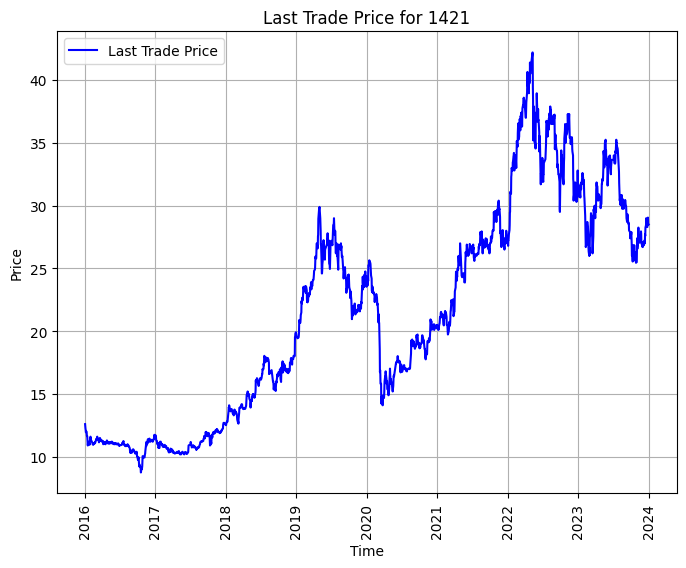

Epoch 1/75
22/22 [==============================] - 17s 627ms/step - loss: 0.1096 - val_loss: 0.0145
Epoch 2/75
22/22 [==============================] - 21s 939ms/step - loss: 0.0362 - val_loss: 0.0117
Epoch 3/75
22/22 [==============================] - 4s 197ms/step - loss: 0.0263 - val_loss: 0.0049
Epoch 4/75
22/22 [==============================] - 4s 200ms/step - loss: 0.0238 - val_loss: 0.0028
Epoch 5/75
22/22 [==============================] - 4s 186ms/step - loss: 0.0196 - val_loss: 0.0030
Epoch 6/75
22/22 [==============================] - 4s 169ms/step - loss: 0.0197 - val_loss: 0.0026
Epoch 7/75
22/22 [==============================] - 4s 185ms/step - loss: 0.0193 - val_loss: 0.0027
Epoch 8/75
22/22 [==============================] - 4s 181ms/step - loss: 0.0188 - val_loss: 0.0037
Epoch 9/75
22/22 [==============================] - 4s 202ms/step - loss: 0.0161 - val_loss: 0.0043
Epoch 10/75
22/22 [==============================] - 4s 187ms/step - loss: 0.0151 - val_loss: 0.00

In [134]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

#target_csv_file = "1428.csv"
#readingData(target_csv_file)


output_directory = r"D:\2 - Price Prediction\LSTM"
csv_files = sorted([csv_file for csv_file in os.listdir(output_directory) if csv_file.endswith('.csv')])
for csv_file in csv_files:
    target_csv_file = csv_file
    readingData(csv_file)